

# **Member**
*   林家誠, 109306066, MIS
*   陳彥竹, 1093060xx, MIS



# **Title**
**url之分析...**

# **Problem Definition**
**Problem Definition**

# **Dataset**
**Dataset**
**介紹**



# **description of your models**
**models**
**介紹**



# **result**
**介紹**



# **discussion**
**介紹**


# 程式碼

## 安裝套件

In [1]:
!pip install transformers
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 下載和解壓檔案

In [2]:
import requests
import zipfile

url = 'https://github.com/Tonyrj3268/DS4CS-FinalProject/raw/main/archive.zip'
response = requests.get(url)
with open('archive.zip', 'wb') as file:
    file.write(response.content)
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## 加載模組

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import string
from urllib.parse import urlparse
import re
from transformers import BertModel, BertTokenizer
import torch
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## gpu check

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## 分析資料集

In [5]:
df = pd.read_csv('/content/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


由於資料集的label分配不均，且資料太過龐大(65萬筆)，使用欠採樣平衡數據集並且縮小訓練資料量，display = True僅供助教和展示時使用(限縮資料量成1萬筆)，原本呈現之結果為欠採樣後之訓練數量。


In [6]:
display = True

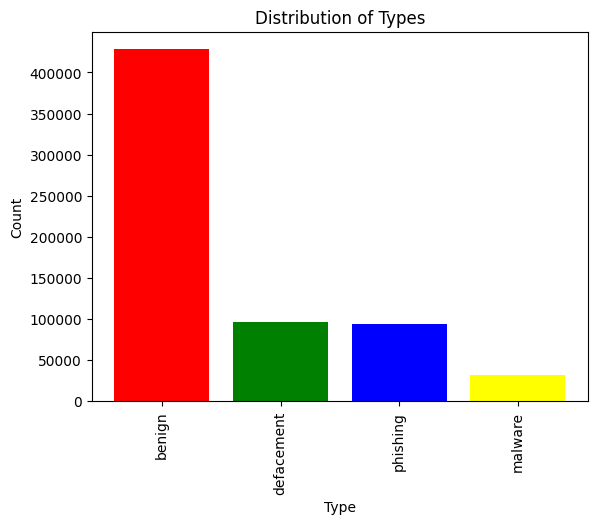

In [7]:
category_counts = df['type'].value_counts()
colors = ['red', 'green', 'blue', 'yellow']
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Distribution of Types")
plt.xticks(rotation='vertical')
plt.show()

In [24]:
X = df[['url']]
y = df['type'] 

under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

print("處理後的樣本數:", len(X_resampled))
print("處理後的樣本分佈:")
print(y_resampled.value_counts())

re_df = pd.concat([X_resampled, y_resampled], axis=1)
if display:
  re_df = re_df.sample(n=10000, random_state=42)

處理後的樣本數: 130080
處理後的樣本分佈:
benign        32520
defacement    32520
malware       32520
phishing      32520
Name: type, dtype: int64


# 預處理

## 特殊字符
計算特殊字符之數量，若完全沒該字符出現，則捨棄此字符欄位。

In [9]:
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=',\
         '{', '}', '[', ']', '|', '\\', ':', ';', '<', '>', ',', '.', '?', '/', '`', '~']  # 定义特殊字符列表

for a in special_chars:
    re_df[a] = re_df['url'].apply(lambda i: i.count(a))
absent_chars = [char for char in special_chars if re_df[char].sum() == 0]
re_df.drop(columns=absent_chars, inplace=True)

## https 檢查 & url長度計算
檢查是否帶有https字串，如有則計為1。  
計算url之總長度

In [10]:
def httpSecure(url):
    http = urlparse(url).scheme
    match = str(http)
    if match=='https':
        return 1
    else:
        return 0
re_df['https'] = re_df['url'].apply(lambda i: httpSecure(i))
re_df['url_len'] = re_df['url'].apply(lambda i: len(str(i)))

In [12]:
re_df.head()

,url,type,!,@,#,%,&,*,(,),...,:,;,>,",",.,?,/,~,https,url_len
0,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,3,0,0,48
1,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,3,0,0,44
2,youtube.com/watch?v=PUDOlyCpHwo,benign,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,31
3,uiowa.edu/~acadtech/phonetics/,benign,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,1,0,30
4,flixster.com/actor/steve-mcqueen,benign,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,32


## 加載bert模型

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
def urlSplitBatch(urls):
    url_parts = [re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', ' ', url)).split(' ') for url in urls]
    tokens = [tokenizer.batch_encode_plus(parts, padding=True, truncation=True, return_tensors='pt') for parts in url_parts]
    input_ids = [token["input_ids"] for token in tokens]
    url_vectors = []
    for ids in input_ids:
      with torch.no_grad():
          ids = ids.to(device)
          last_hidden_states = model(ids)[0]
      url_vectors.append(last_hidden_states.mean(dim=[0, 1]).unsqueeze(0))

    url_vectors = torch.cat(url_vectors, dim=0).to(device)
    return url_vectors


# 在主要迴圈中使用批次處理
BATCH_SIZE = 100  # 你可以根據你的硬體配置和需求來調整批次的大小
word_vector = []
rows_to_drop = []
total = len(re_df['url'])
checkpoint = total // 100
for i in range(0, total, BATCH_SIZE):
  batch = re_df['url'][i:i+BATCH_SIZE]
  try:
    split_urls = urlSplitBatch(batch)  # 對整個批次進行split操作
  except:
    print(f"第{i}批資料集發生錯誤，跳過並移除")
    rows_to_drop.extend(range(i, min(i+BATCH_SIZE, len(re_df['url']))))  # 若split操作失敗，將整個批次的索引加入要刪除的列表
    continue

  list_from_tensor = split_urls.tolist()
  word_vector.extend(list_from_tensor)

  if (i + BATCH_SIZE) % checkpoint == 0:
      print("已完成：{:.0f}%".format((i + BATCH_SIZE) / len(re_df['url']) * 100))

已完成：1%
已完成：2%
已完成：3%
已完成：4%
已完成：5%
已完成：6%
已完成：7%
已完成：8%
已完成：9%
已完成：10%
已完成：11%
已完成：12%
已完成：13%
已完成：14%
已完成：15%
已完成：16%
已完成：17%
已完成：18%
已完成：19%
已完成：20%
已完成：21%
已完成：22%
已完成：23%
已完成：24%
已完成：25%
已完成：26%
已完成：27%
已完成：28%
已完成：29%
已完成：30%
已完成：31%
已完成：32%
已完成：33%
已完成：34%
已完成：35%
已完成：36%
已完成：37%
已完成：38%
已完成：39%
已完成：40%
已完成：41%
已完成：42%
已完成：43%
已完成：44%
已完成：45%
已完成：46%
已完成：47%
已完成：48%
已完成：49%
已完成：50%
已完成：51%
已完成：52%
已完成：53%
已完成：54%
已完成：55%
已完成：56%
已完成：57%
已完成：58%
已完成：59%
已完成：60%
已完成：61%
已完成：62%
已完成：63%
已完成：64%
已完成：65%
已完成：66%
已完成：67%
已完成：68%
已完成：69%
已完成：70%
已完成：71%
已完成：72%
已完成：73%
已完成：74%
已完成：75%
已完成：76%
已完成：77%
已完成：78%
已完成：79%
已完成：80%
已完成：81%
已完成：82%
已完成：83%
已完成：84%
已完成：85%
已完成：86%
已完成：87%
已完成：88%
已完成：89%
已完成：90%
已完成：91%
已完成：92%
已完成：93%
已完成：94%
已完成：95%
已完成：96%
已完成：97%
已完成：98%
已完成：99%
已完成：100%


In [15]:
word_vector_array = word_vector
feature_array = re_df.drop(['url', 'type'], axis=1).to_numpy()
merged_array = np.hstack((feature_array, word_vector_array))

target = pd.get_dummies(re_df['type'], columns=['type'])

In [23]:
re_df['type'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: type
Non-Null Count  Dtype 
--------------  ----- 
10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [20]:
target.values.ravel()

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [16]:

feature_arrays = [feature_array, word_vector_array, merged_array]
feature_name = ["feature_array", "word_vector_array", "merged_array"]

# 定义模型列表
models = [DecisionTreeClassifier(), RandomForestClassifier()]

# 打印表格标题
print("{:<20s} {:<20s} {:<10s}".format("特徵", "模型", "準確率"))
print("="*50)

# 循环遍历特征数组和模型进行训练和评估
for i,features in enumerate(feature_arrays):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    for model in models:
        # 创建分类器
        classifier = model

        # 在训练集上训练分类器
        classifier.fit(X_train, y_train)

        # 在测试集上进行预测
        y_pred = classifier.predict(X_test)

        # 在测试集上评估模型性能
        accuracy = classifier.score(X_test, y_test)

        # 打印结果行
        print("{:<20s} {:<20s} {:.4f}".format(feature_name[i], model.__class__.__name__, accuracy))

# 打印表格底部分隔线
print("="*50)

特徵                   模型                   準確率       
feature_array        DecisionTreeClassifier 1.0000


<ipython-input-16-9b0839030fe6>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


feature_array        RandomForestClassifier 1.0000
word_vector_array    DecisionTreeClassifier 1.0000


<ipython-input-16-9b0839030fe6>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


word_vector_array    RandomForestClassifier 1.0000
merged_array         DecisionTreeClassifier 1.0000


<ipython-input-16-9b0839030fe6>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


merged_array         RandomForestClassifier 1.0000


In [ ]:

features_train, features_test, labels_train, labels_test = train_test_split(feature_array, target.values, test_size=0.2, random_state=42)

# 将numpy数组转换为torch tensors
features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32)
features_test = torch.tensor(features_test, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)

# 创建TensorDataset
train_dataset = TensorDataset(features_train, labels_train)
test_dataset = TensorDataset(features_test, labels_test)

# 创建DataLoader
batch_size = 1024  # 你可以根据你的硬件和模型的需求设置这个值
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 在训练阶段，shuffle应该设为True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # 在测试阶段，shuffle通常设为False


In [ ]:

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(32, 600)
#         self.bn1 = nn.BatchNorm1d(600)
#         self.fc2 = nn.Linear(600, 400)
#         self.bn2 = nn.BatchNorm1d(400)
#         self.fc3 = nn.Linear(400, 200)
#         self.bn3 = nn.BatchNorm1d(200)
#         self.fc4 = nn.Linear(200, 100)
#         self.dropout = nn.Dropout(0.5)
#         self.fc5 = nn.Linear(100, 4)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = F.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = F.relu(self.bn3(self.fc3(x)))
#         x = self.dropout(x)
#         x = F.relu(self.fc4(x))
#         x = self.fc5(x)
#         return x
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32, 128)  # 输入的特征维度是800，我们使用500个神经元的隐藏层
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 4)   # 假设你有4个类别

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 实例化网络
net = Net().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 训练
# 训练
for epoch in range(30):  # 假设我们训练10个epoch
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):  # 假设你的数据已经被封装在DataLoader中
        # 获取输入
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.argmax(dim=1).to(device)  # 取得one-hot编码的标签的最大值的索引作为类别标签

        # 梯度清零
        optimizer.zero_grad()

        # 前向+后向+优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 10 == 9:    # 每2000批次打印一次
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # 在每个epoch之后，用测试集评估模型性能
    correct = 0
    total = 0
    with torch.no_grad():  # 禁用梯度计算
        for data in test_dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.argmax(dim=1).to(device)  # 取得one-hot编码的标签的最大值的索引作为类别标签
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)  # 取得预测的类别
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

print('Finished Training')



[1,    10] loss: 0.00718
[1,    20] loss: 0.00648
[1,    30] loss: 0.00614
[1,    40] loss: 0.00589
[1,    50] loss: 0.00566
[1,    60] loss: 0.00542
[1,    70] loss: 0.00524
[1,    80] loss: 0.00499
[1,    90] loss: 0.00478
[1,   100] loss: 0.00463
Accuracy of the network on the test data: 63 %
[2,    10] loss: 0.00443
[2,    20] loss: 0.00430
[2,    30] loss: 0.00420
[2,    40] loss: 0.00408
[2,    50] loss: 0.00393
[2,    60] loss: 0.00390
[2,    70] loss: 0.00381
[2,    80] loss: 0.00378
[2,    90] loss: 0.00373
[2,   100] loss: 0.00363
Accuracy of the network on the test data: 74 %
[3,    10] loss: 0.00344
[3,    20] loss: 0.00345
[3,    30] loss: 0.00341
[3,    40] loss: 0.00331
[3,    50] loss: 0.00340
[3,    60] loss: 0.00333
[3,    70] loss: 0.00325
[3,    80] loss: 0.00331
[3,    90] loss: 0.00323
[3,   100] loss: 0.00320
Accuracy of the network on the test data: 76 %
[4,    10] loss: 0.00318
[4,    20] loss: 0.00307
[4,    30] loss: 0.00310
[4,    40] loss: 0.00301
[4,    50